<a href="https://colab.research.google.com/github/luancordeiro/lidarpy/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/luancordeiro/lidarpy.git

Cloning into 'lidarpy'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 315 (delta 58), reused 78 (delta 34), pack-reused 205
Receiving objects: 100% (315/315), 67.79 MiB | 34.06 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [3]:
import os
os.chdir("lidarpy")

In [4]:
from lidarpy import GetData

directory = "/content/lidarpy/lidarpy/tests/data/binary"
files = [file for file in os.listdir(directory) if file.startswith("RM")]
files.sort()

data = GetData(directory, files)
lidar_data = data.get_xarray()
lidar_data

<xarray.DataArray (time: 119, wavelength: 5, altitude: 16380)>
array([[[  1.98522949,   1.98376465,   1.98392741, ...,   1.98954264,
           1.98669434,   1.98819987],
        [113.93333333, 104.9       , 100.43333333, ...,   0.        ,
           0.        ,   0.        ],
        [  2.02790527,   2.02873535,   2.02804362, ...,   2.03680013,
           2.0347168 ,   2.03548991],
        [ 61.33333333,  50.        ,  40.2       , ...,   0.        ,
           0.        ,   0.        ],
        [  2.3       ,   1.4       ,   1.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  1.98494466,   1.98417155,   1.98494466, ...,   1.98868815,
           1.98775228,   1.98954264],
        [114.5       , 103.03333333, 101.16666667, ...,   0.        ,
           0.        ,   0.        ],
        [  2.02931315,   2.02963053,   2.02929688, ...,   2.03629557,
           2.03545736,   2.03633626],
        [ 59.2       ,  50.63333333,  39.36666667, ...,   0.        ,
           0.        ,   0.        ],
        [  2.13333333,   1.4       ,   0.93333333, ...,   0.        ,
...
           1.98673503,   1.98636882],
        [116.96666667, 108.        , 101.6       , ...,   0.        ,
           0.        ,   0.        ],
        [  2.02666829,   2.02672526,   2.02703451, ...,   2.03343913,
           2.03416341,   2.03550618],
        [ 62.13333333,  49.3       ,  39.33333333, ...,   0.        ,
           0.        ,   0.        ],
        [  2.3       ,   1.86666667,   0.9       , ...,   0.        ,
           0.        ,   0.        ]],

       [[  1.98010254,   1.98262533,   1.9802653 , ...,   1.98616536,
           1.9868571 ,   1.98506673],
        [117.4       , 108.33333333, 104.23333333, ...,   0.        ,
           0.        ,   0.        ],
        [  2.02862142,   2.02786458,   2.02790527, ...,   2.03475749,
           2.03473307,   2.0342041 ],
        [ 63.16666667,  49.2       ,  40.4       , ...,   0.        ,
           0.        ,   0.        ],
        [  2.56666667,   1.33333333,   0.8       , ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * time        (time) float64 7.35e+05 7.35e+05 7.35e+05 ... 7.35e+05 7.35e+05
  * wavelength  (wavelength) <U5 '355_0' '355_1' '387_0' '387_1' '408_1'
  * altitude    (altitude) float64 7.5 15.0 22.5 ... 1.228e+05 1.228e+05

# Removing background noise

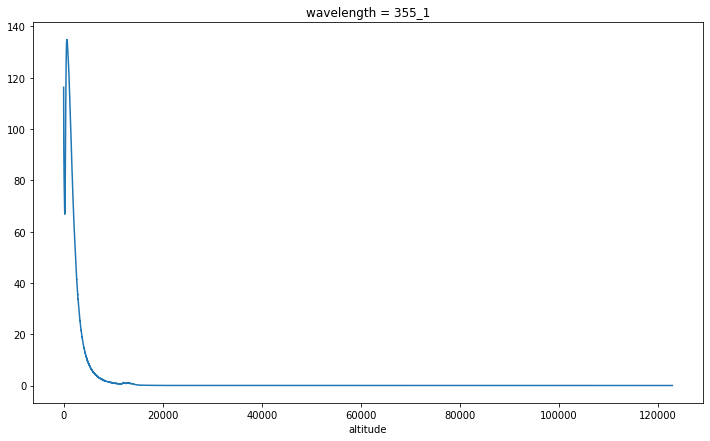

In [5]:
(lidar_data
 .mean("time")
 .sel(wavelength="355_1")
 .plot(figsize=(12, 7)))

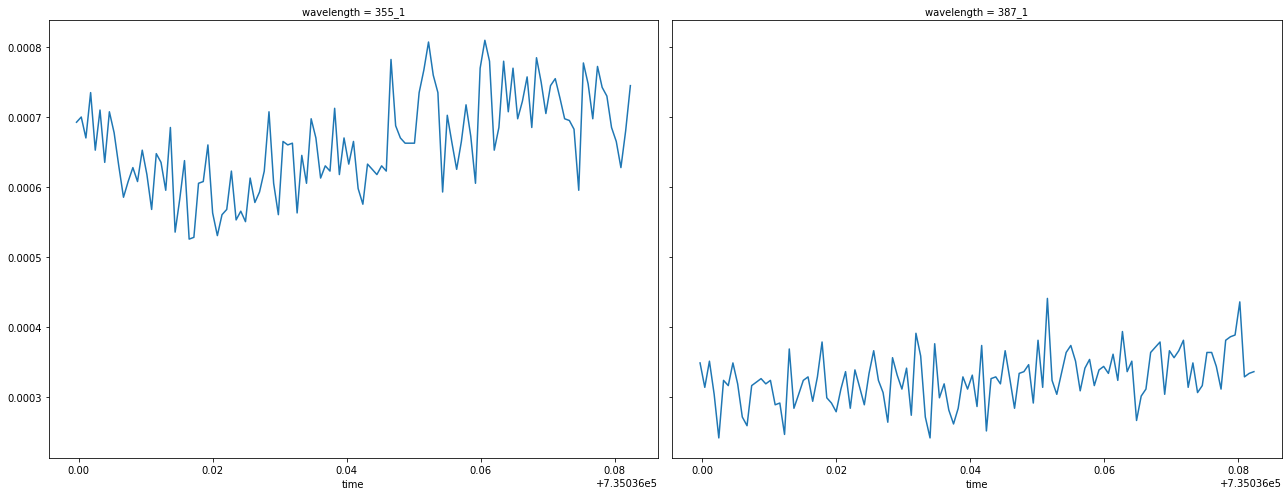

In [6]:
lidar_data[:,[1,3],3000:].mean("altitude").plot(col="wavelength", figsize=(18, 7))

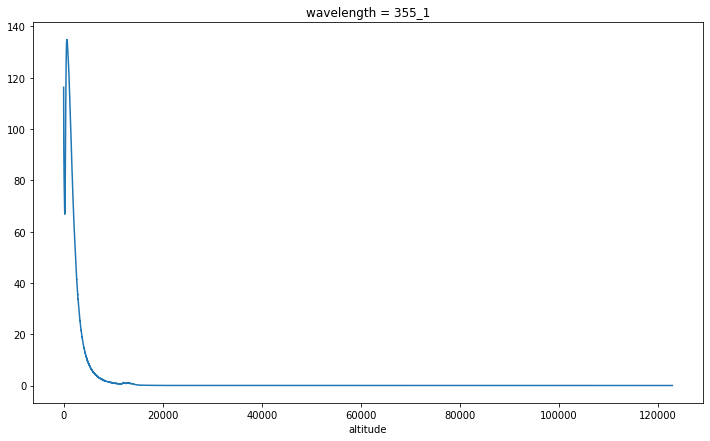

In [7]:
from lidarpy.data.clean import remove_background

lidar_clean = lidar_data.pipe(remove_background, [25_000, 80_000])

(lidar_clean
 .mean("time")
 .sel(wavelength="355_1")
 .plot(figsize=(12, 7)))

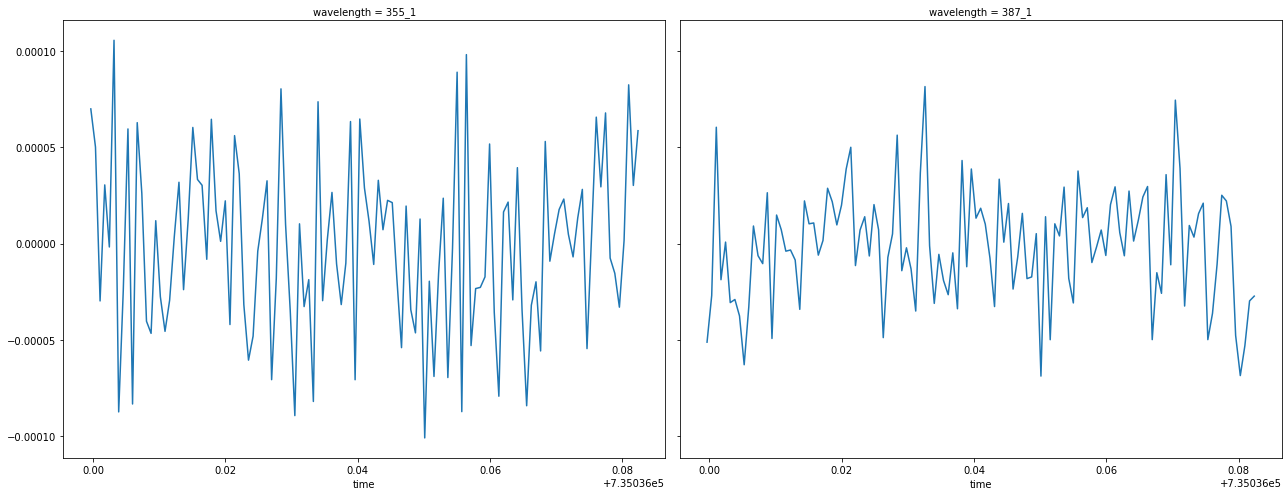

In [8]:
lidar_clean[:,[1,3],3000:].mean("altitude").plot(col="wavelength", figsize=(18, 7))

In [9]:
rcs_data = lidar_clean * lidar_clean.coords["altitude"] ** 2

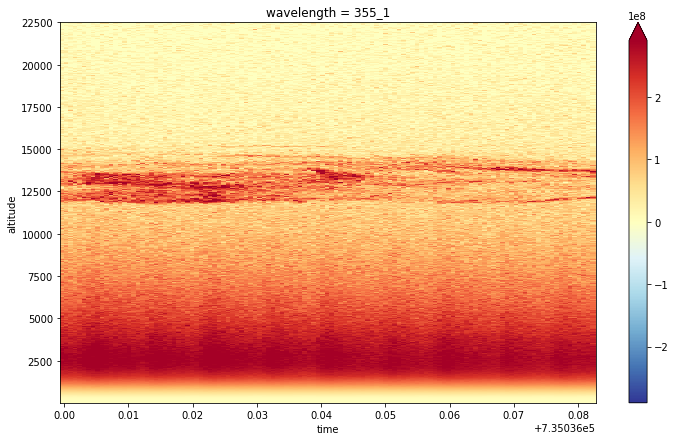

In [10]:
rcs_data[:, 1, 0:3000].plot(x="time", y="altitude", figsize=(12, 7), 
                            robust=True, cmap="RdYlBu_r")

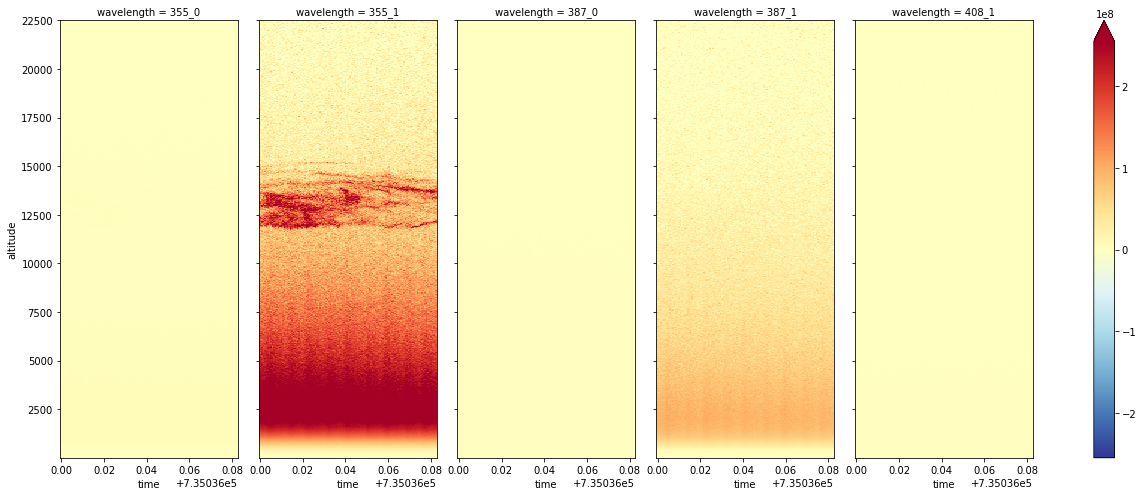

In [11]:
rcs_data[:, :, 0:3000].plot(x="time", col="wavelength", y="altitude", 
                            figsize=(18, 7), robust=True, cmap="RdYlBu_r")

In [12]:
rcs_data_mean = rcs_data.mean("time")

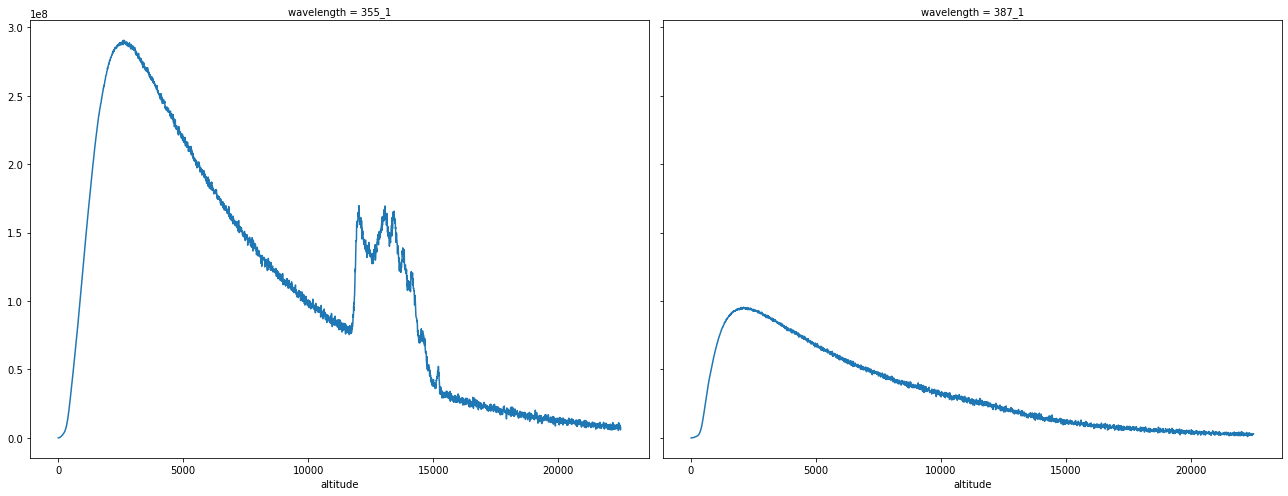

In [13]:
rcs_data_mean[[1,3], :3000].plot(col="wavelength", figsize=(18, 7))

# High level computation: groupby, resamble, rolling, coarsen, weighted

In [14]:
import numpy as np

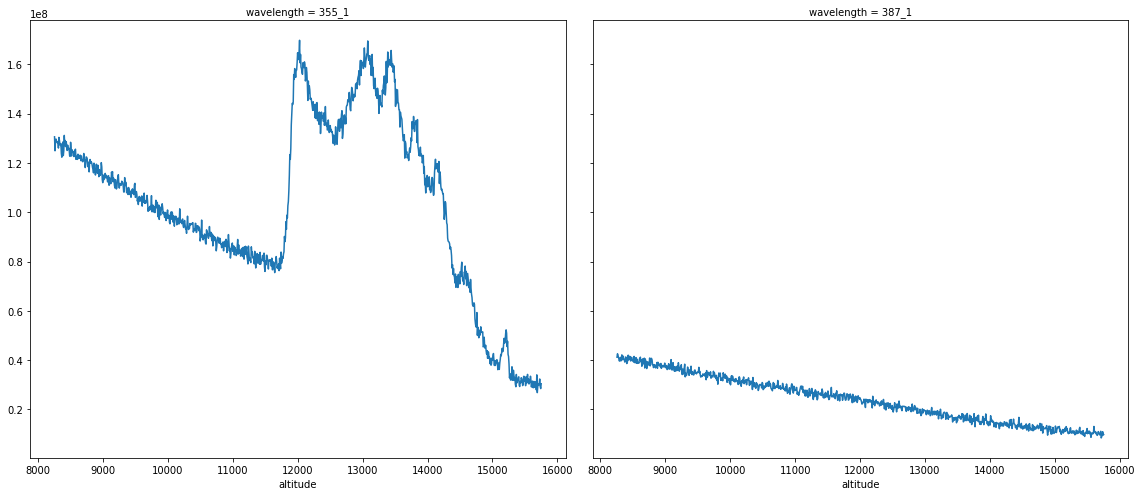

In [15]:
rcs_mean = rcs_data.mean("time")

rcs_mean[[1,3], 1100:2100].plot(col="wavelength", figsize=(16, 7))

In [16]:
rcs_mean[[1,3], 1100:2100].coords["altitude"]

<xarray.DataArray 'altitude' (altitude: 1000)>
array([ 8257.5,  8265. ,  8272.5, ..., 15735. , 15742.5, 15750. ])
Coordinates:
  * altitude  (altitude) float64 8.258e+03 8.265e+03 ... 1.574e+04 1.575e+04

# Inversão Raman

## Pré-processamento

In [17]:
rcs_mean

<xarray.DataArray (wavelength: 5, altitude: 16380)>
array([[-2.19884172e-01, -8.54301986e-01, -1.94000917e+00, ...,
         9.05347076e+06,  1.23517361e+07,  1.23687259e+07],
       [ 6.54071901e+03,  2.39120567e+04,  5.07152789e+04, ...,
        -1.00025286e+07, -1.00037501e+07, -1.00049717e+07],
       [-2.71246654e-01, -1.07584673e+00, -2.42629833e+00, ...,
         3.04940900e+07,  3.15679719e+07,  3.18990027e+07],
       [ 3.54620527e+03,  1.12813757e+04,  2.01606373e+04, ...,
        -4.95487359e+06, -4.95547868e+06, -7.28598502e+05],
       [ 1.33761850e+02,  3.22274290e+02,  5.09003707e+02, ...,
        -2.45669064e+06,  1.76997848e+06,  5.99767991e+06]])
Coordinates:
  * wavelength  (wavelength) <U5 '355_0' '355_1' '387_0' '387_1' '408_1'
  * altitude    (altitude) float64 7.5 15.0 22.5 ... 1.228e+05 1.228e+05

In [19]:
def groupby_nbins(ds, n_bins):
  if n_bins in [0, 1]:
    return ds

  alt = ds.coords["altitude"].data

  mean = alt[:n_bins].mean()

  print(mean)

  return (ds
            .assign_coords(altitude=np.arange(len(alt)) // n_bins)
            .groupby("altitude")
            .mean()
            .assign_coords(altitude=lambda x: [alt[i * n_bins:(i + 1) * n_bins].mean() for i in range(len(x.altitude))])
          )

30.0


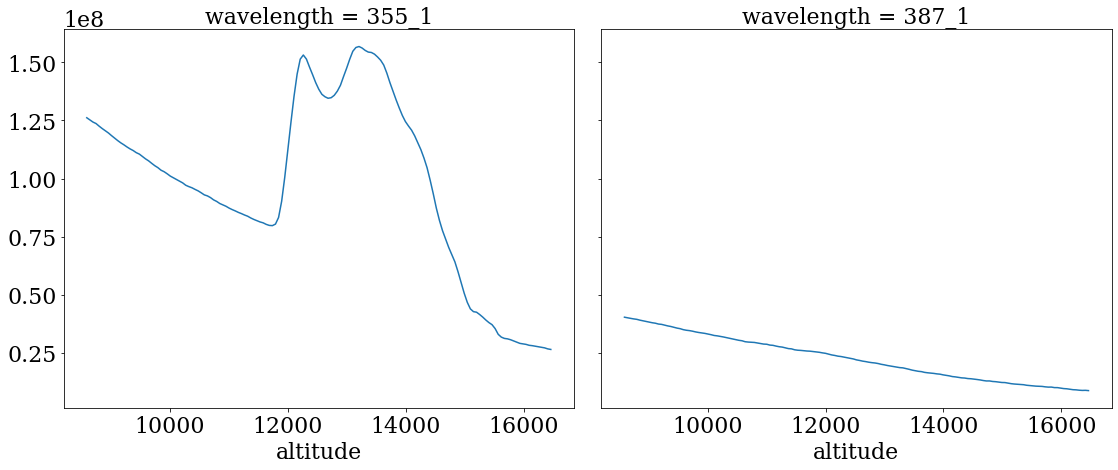

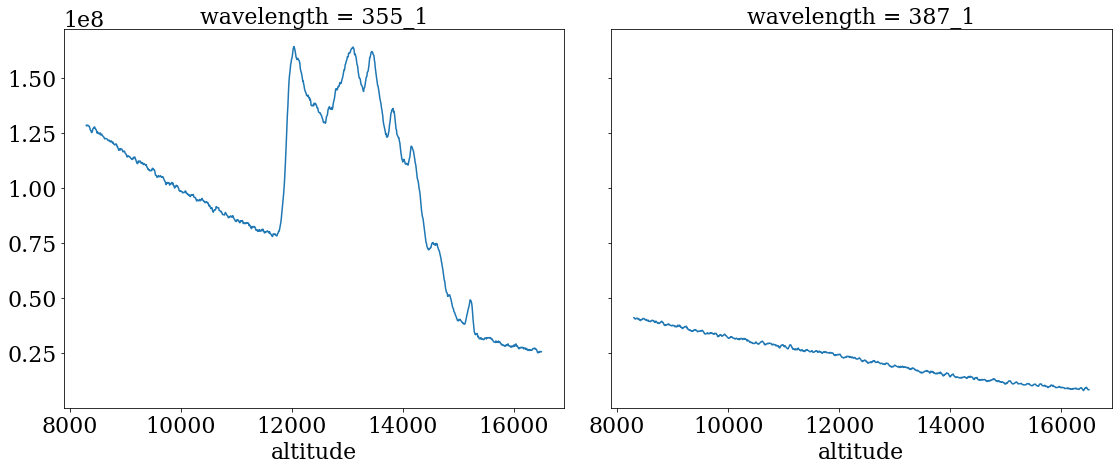

In [106]:
WINDOW = 7
nbins = 7

(rcs_mean
 .pipe(groupby_nbins, nbins)
 [[1, 3], 1100 // nbins:2200 // nbins]
 .rolling(altitude=WINDOW)
 .mean()
 .plot(col="wavelength", figsize=(16, 7)))

(rcs_mean
 [[1,3], 1100:2200]
 .rolling(altitude=WINDOW)
 .mean()
 .plot(col="wavelength", figsize=(16, 7)))

In [107]:
ds = (lidar_clean
      .mean("time")
      .pipe(groupby_nbins, nbins)
      [[1, 3], 1100 // nbins:2100 // nbins]
      .rolling(altitude=WINDOW)
      .mean()
      .dropna("altitude"))
ds

30.0


<xarray.DataArray (wavelength: 2, altitude: 137)>
array([[1.77693383, 1.74195412, 1.70795766, 1.6785802 , 1.64300025,
        1.60953544, 1.57803712, 1.54684179, 1.51409155, 1.48273615,
        1.45202672, 1.42306085, 1.39631872, 1.36901637, 1.34336611,
        1.31981955, 1.29438081, 1.27261781, 1.24667601, 1.22142591,
        1.19830809, 1.17332667, 1.14948285, 1.12795423, 1.10407611,
        1.08531432, 1.06436308, 1.04283447, 1.02436423, 1.00621411,
        0.98822406, 0.97074278, 0.95069476, 0.93521428, 0.92083139,
        0.90481355, 0.88961318, 0.87294938, 0.85600545, 0.84347473,
        0.82845158, 0.81149622, 0.79750777, 0.78182721, 0.76905067,
        0.75661713, 0.74258294, 0.72997218, 0.71825321, 0.70608835,
        0.69511824, 0.68365652, 0.67313802, 0.66086454, 0.64972294,
        0.63963891, 0.62936623, 0.62062559, 0.6099699 , 0.6010006 ,
        0.5947924 , 0.59418644, 0.60913528, 0.65335868, 0.72055127,
        0.79866252, 0.87387546, 0.94565846, 1.00494503, 1.04204559,
        1.04623012, 1.02576479, 0.99383201, 0.96341985, 0.93251034,
        0.90576822, 0.88399379, 0.86966235, 0.85808629, 0.85223252,
        0.85132358, 0.85528517, 0.86363136, 0.87941482, 0.89402066,
        0.91005565, 0.92322663, 0.92566761, 0.9210772 , 0.91037577,
        0.89732484, 0.88597744, 0.87763696, 0.86639247, 0.85280417,
        0.83858706, 0.82110578, 0.79622154, 0.76794737, 0.74151966,
...
        0.2671386 , 0.26357717, 0.26040448, 0.25581978, 0.25146376,
        0.24683905, 0.24390645, 0.23853287, 0.23528014, 0.23036389,
        0.22599071, 0.2226065 , 0.21788461, 0.21327134, 0.21040162,
        0.20533102, 0.20196967, 0.19948868, 0.19667041, 0.19384071,
        0.19157694, 0.18878154, 0.18612905, 0.18303067, 0.17962359,
        0.17663954, 0.17271797, 0.16868779, 0.16565801, 0.16214231,
        0.15963846, 0.15647147, 0.15317873, 0.15045192, 0.14741071,
        0.14354059, 0.14073375, 0.13760679, 0.13513723, 0.13235897,
        0.13005519, 0.12811728, 0.12563628, 0.12261793, 0.12020554,
        0.11747302, 0.11513494, 0.11296836, 0.11039018, 0.10842368,
        0.10698311, 0.10446782, 0.10179818, 0.09899134, 0.09672186,
        0.09460101, 0.09308612, 0.09060513, 0.08893017, 0.08760964,
        0.08614048, 0.08442551, 0.08309927, 0.08092697, 0.07932633,
        0.07750846, 0.07537046, 0.07409567, 0.07246644, 0.07089439,
        0.06995687, 0.06835623, 0.06746444, 0.06628683, 0.064932  ,
        0.06357717, 0.06191937, 0.06058741, 0.06018153, 0.05870094,
        0.05784917, 0.05656294, 0.05548251, 0.05493372, 0.05344169,
        0.05205256, 0.05101215, 0.05020039, 0.04930861, 0.04870837,
        0.04734211, 0.04648462, 0.04572432, 0.04477537, 0.04423229,
        0.0436835 , 0.04264309]])
Coordinates:
  * wavelength  (wavelength) <U5 '355_1' '387_1'
  * altitude    (altitude) float64 8.588e+03 8.64e+03 ... 1.568e+04 1.573e+04

## Parâmetros atmosféricos

In [108]:
z = ds.coords["altitude"].data
z.shape

(137,)

In [109]:
z[1] - z[0]

52.5

In [18]:
import pandas as pd
from scipy.interpolate import interp1d

df_sonde = pd.read_csv("lidarpy/tests/data/sonde_data.txt")

f_temp = interp1d(df_sonde["alt"].to_numpy(), df_sonde["temp"].to_numpy())
f_pres = interp1d(df_sonde["alt"].to_numpy(), df_sonde["pres"].to_numpy())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7952ecdd0>,
      dtype=object)

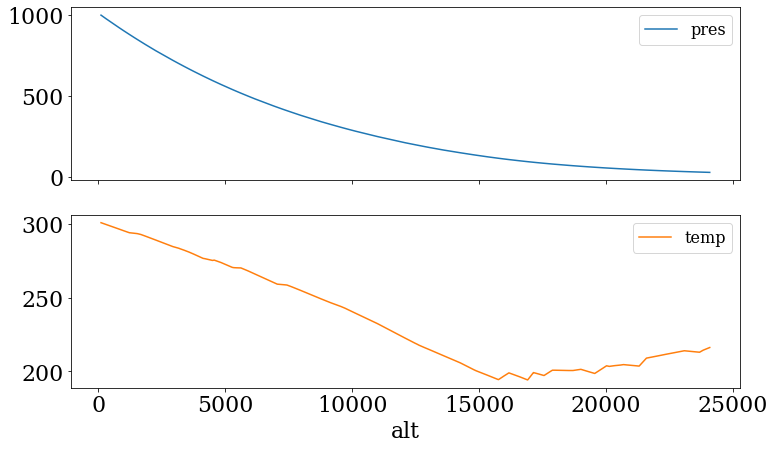

In [111]:
df_sonde.plot(x="alt", subplots=True, figsize=(12, 7))

In [113]:
temperature = f_temp(z)
pressure = f_pres(z)

temperature.shape, pressure.shape

((137,), (137,))

## Inversão

In [114]:
from lidarpy.inversion.raman import Raman, diff_

raman = Raman(ds,
              355,
              387,
              0,
              pressure,
              temperature,
              10_000)

In [122]:
alpha, beta, lr = raman.fit(diff_window=21)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which 

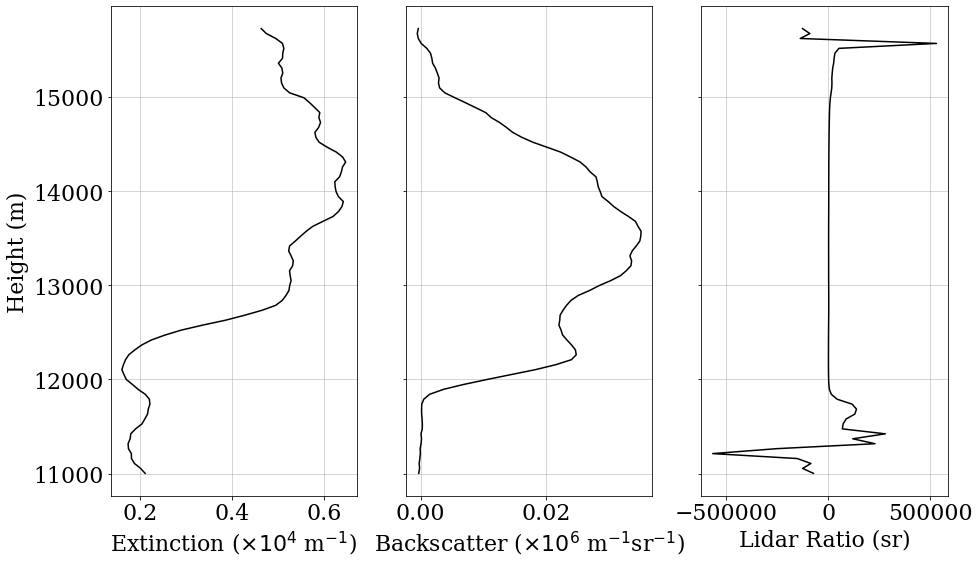

In [123]:
from lidarpy.plot.plotter import plot_3graph_std

z_min = 11_000
plot_3graph_std(z[[z>z_min]], 
                alpha[[z>z_min]], 
                beta[[z>z_min]], 
                lr[[z>z_min]])

# Inversão Klett

In [29]:
import pandas as pd
from scipy.interpolate import interp1d
from lidarpy.inversion.klett import Klett

da_klett = lidar_clean.mean("time")[[1], 1100:2100]
z_klett = da_klett.coords["altitude"]


df_sonde = pd.read_csv("lidarpy/tests/data/sonde_data.txt")

f_temp = interp1d(df_sonde["alt"].to_numpy(), df_sonde["temp"].to_numpy())
f_pres = interp1d(df_sonde["alt"].to_numpy(), df_sonde["pres"].to_numpy())

temperature = f_temp(z_klett)
pressure = f_pres(z_klett)

In [31]:
from lidarpy.inversion.klett import Klett

In [36]:
klett = Klett(da_klett, 
              [9000, 11000],
              355,
              19,
              pressure,
              temperature
              )

In [37]:
alpha, beta, lr = klett.fit()

lidar ratio: 19


ValueError: ignored